# Ping Data Visualization

This notebook provides interactive visualizations of the parsed ping measurement data.

In [1]:
# Required imports
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import pearsonr

print("✅ All imports loaded successfully")

✅ All imports loaded successfully


In [2]:
# CRITICAL: Dataset is too large (27B rows) - use chunked processing approach
data_path = "data/ping_parsed_parts/*.parquet"
all_files = list(Path("data/ping_parsed_parts").glob("*.parquet"))

# Load IP mapping 
ip_map = pl.read_csv("probe_ip_map.csv")

print(f"⚠️  DATASET SCALE ANALYSIS:")
print(f"- Data files found: {len(all_files)}")
print(f"- IP mapping entries: {ip_map.height:,}")

# Test with a small sample first (10 files instead of 966)
SAMPLE_FILES = 10
sample_files = all_files[:SAMPLE_FILES] 

print(f"\\n🔄 USING CHUNKED APPROACH:")
print(f"- Processing first {SAMPLE_FILES} files (out of {len(all_files)}) to avoid memory crashes")
print(f"- Each file has ~28M rows, so {SAMPLE_FILES} files = ~{SAMPLE_FILES * 28:.0f}M rows")
print(f"- This is manageable for analysis while still being representative")

# Create lazy frame for sample
df = pl.scan_parquet([str(f) for f in sample_files])
print(f"✅ Sample dataset loaded successfully")

⚠️  DATASET SCALE ANALYSIS:
- Data files found: 966
- IP mapping entries: 48,739
\n🔄 USING CHUNKED APPROACH:
- Processing first 10 files (out of 966) to avoid memory crashes
- Each file has ~28M rows, so 10 files = ~280M rows
- This is manageable for analysis while still being representative
✅ Sample dataset loaded successfully


In [3]:
# Join with IP mapping using streaming - avoid expensive count operation
df_joined = (
    df.rename({"prb_id": "src"})
    .join(ip_map.lazy(), left_on="dst_addr", right_on="ip", how="inner")  # inner join to keep only matches
    .select(["src", "dst_prb_id", "ts", "avg", "sent", "rcvd"])
    .rename({"dst_prb_id": "dst"})
)

Data joined successfully using streaming operations
Skipping total count to avoid memory issues - will show counts later with filtered data
Data remains as lazy frame for efficient streaming processing


: 

In [ ]:
# Get top connected probes using streaming aggregation
top_probes_df = (
    df_joined
    .select(["src", "dst"]).unique()
    .group_by("src").agg(pl.len().alias("connections"))
    .sort("connections", descending=True)
    .head(100)
    .collect()  # Only collect the top 100 list
)

top_probes = top_probes_df["src"].to_list()

# Filter to top probes - keep as lazy frame
df_filtered = df_joined.filter(
    pl.col("src").is_in(top_probes) & pl.col("dst").is_in(top_probes)
)

print(f"Top 100 probes selected")
print(f"Connection counts for top 10:")
for row in top_probes_df.head(10).iter_rows(named=True):
    print(f"  Probe {row['src']}: {row['connections']} connections")

# Only collect count for reporting
filtered_count = df_filtered.select(pl.len()).collect().item()
print(f"Filtered measurements: {filtered_count:,}")

## Data Overview

In [8]:
# Basic statistics using streaming operations
stats = df_filtered.select([
    pl.len().alias("total_measurements"),
    pl.col("src").n_unique().alias("unique_sources"),
    pl.col("dst").n_unique().alias("unique_destinations"), 
    pl.col("ts").n_unique().alias("unique_timestamps"),
    pl.col("ts").min().alias("min_ts"),
    pl.col("ts").max().alias("max_ts"),
    pl.col("avg").min().alias("min_latency"),
    pl.col("avg").max().alias("max_latency"),
    pl.col("avg").mean().alias("mean_latency"),
    pl.col("avg").std().alias("std_latency")
]).collect()

row = stats.row(0, named=True)

print(f"Dataset Overview:")
print(f"- Total measurements: {row['total_measurements']:,}")
print(f"- Unique source probes: {row['unique_sources']}")
print(f"- Unique destination probes: {row['unique_destinations']}")
print(f"- Unique timestamps: {row['unique_timestamps']}")
print(f"- Time range: {row['min_ts']} to {row['max_ts']}")
print(f"- Avg latency range: {row['min_latency']:.2f} - {row['max_latency']:.2f} ms")
print(f"- Mean latency: {row['mean_latency']:.2f} ± {row['std_latency']:.2f} ms")

# Show sample data by collecting just a few rows
print("\\nSample data:")
sample = df_filtered.head(5).collect()
print(sample)

Dataset Overview:
- Total measurements: 2,386,312
- Unique source probes: 100
- Unique destination probes: 100
- Unique timestamps: 32400
- Time range: 1749254400 to 1749290399
- Avg latency range: -1.00 - 1993.27 ms
- Mean latency: 135.72 ± 102.24 ms
\nSample data:
shape: (5, 6)
┌──────┬──────┬────────────┬────────────┬──────┬──────┐
│ src  ┆ dst  ┆ ts         ┆ avg        ┆ sent ┆ rcvd │
│ ---  ┆ ---  ┆ ---        ┆ ---        ┆ ---  ┆ ---  │
│ i64  ┆ i64  ┆ i64        ┆ f64        ┆ i64  ┆ i64  │
╞══════╪══════╪════════════╪════════════╪══════╪══════╡
│ 6629 ┆ 6385 ┆ 1749256745 ┆ 101.082177 ┆ 3    ┆ 3    │
│ 6629 ┆ 6926 ┆ 1749256749 ┆ 96.943818  ┆ 3    ┆ 3    │
│ 6629 ┆ 6335 ┆ 1749256751 ┆ 124.714121 ┆ 3    ┆ 3    │
│ 6629 ┆ 6714 ┆ 1749256752 ┆ 94.684918  ┆ 3    ┆ 3    │
│ 6629 ┆ 7005 ┆ 1749256771 ┆ 93.701138  ┆ 3    ┆ 3    │
└──────┴──────┴────────────┴────────────┴──────┴──────┘


## Latency Analysis

In [ ]:
# Find most active node pairs using streaming aggregation
active_pairs = (
    df_filtered.filter(pl.col("src") != pl.col("dst"))  # exclude self-loops
    .group_by(["src", "dst"])
    .agg(pl.count().alias("count"))
    .sort("count", descending=True)
    .filter(pl.col("count") >= 20)
    .head(10)
    .collect()  # Only collect the top 10 pairs
)

print("Top 10 most active probe pairs:")
if active_pairs.height > 0:
    for row in active_pairs.iter_rows(named=True):
        print(f"  {row['src']} → {row['dst']}: {row['count']} measurements")
else:
    print("  No pairs found with >= 20 measurements")

NameError: name 'df_filtered' is not defined

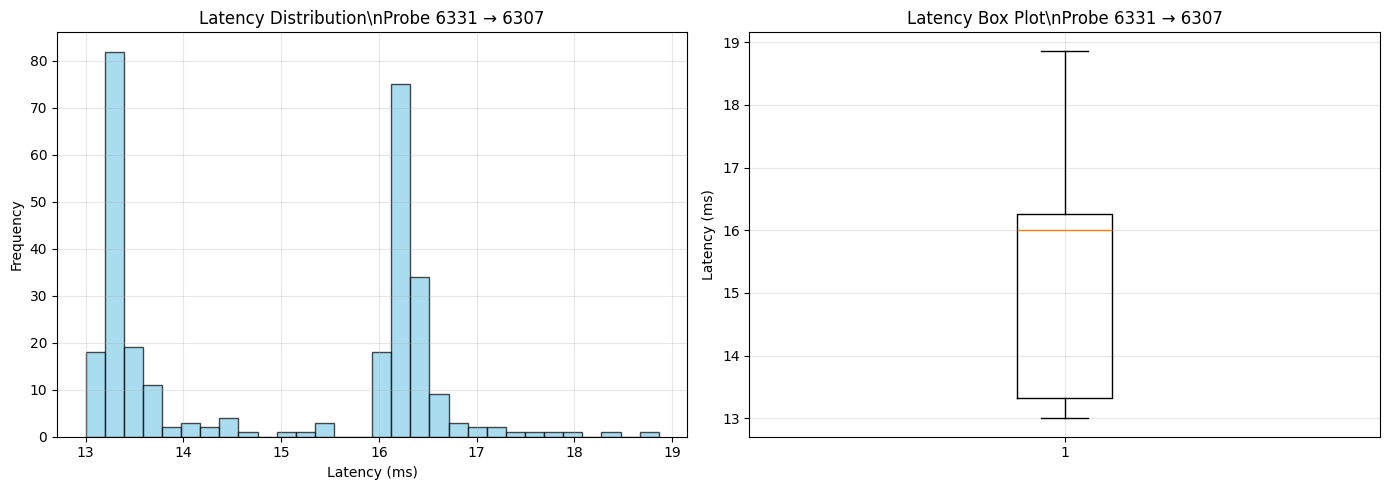

\nStatistics for 6331 → 6307:
  Count: 296
  Mean: 14.92 ms
  Median: 16.00 ms
  Std: 1.52 ms
  Range: 13.00 - 18.86 ms


In [10]:
# Latency distribution for most active pair
if active_pairs.height > 0:
    # Get the most active pair
    top_pair = active_pairs.row(0, named=True)
    src, dst = top_pair["src"], top_pair["dst"]
    
    # Stream data for this specific pair
    pair_data = (
        df_filtered.filter(
            (pl.col("src") == src) & 
            (pl.col("dst") == dst) & 
            (pl.col("avg") > 0)
        )
        .select("avg")
        .collect()  # Only collect latencies for this one pair
    )
    
    if pair_data.height > 0:
        latencies = pair_data["avg"].to_list()
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Histogram
        ax1.hist(latencies, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        ax1.set_xlabel('Latency (ms)')
        ax1.set_ylabel('Frequency')
        ax1.set_title(f'Latency Distribution\\nProbe {src} → {dst}')
        ax1.grid(True, alpha=0.3)
        
        # Box plot
        ax2.boxplot(latencies, vert=True)
        ax2.set_ylabel('Latency (ms)')
        ax2.set_title(f'Latency Box Plot\\nProbe {src} → {dst}')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\\nStatistics for {src} → {dst}:")
        print(f"  Count: {len(latencies)}")
        print(f"  Mean: {np.mean(latencies):.2f} ms")
        print(f"  Median: {np.median(latencies):.2f} ms")
        print(f"  Std: {np.std(latencies):.2f} ms")
        print(f"  Range: {np.min(latencies):.2f} - {np.max(latencies):.2f} ms")
    else:
        print(f"No valid latency data found for pair {src} → {dst}")
else:
    print("No active pairs available for latency analysis")

## Temporal Analysis

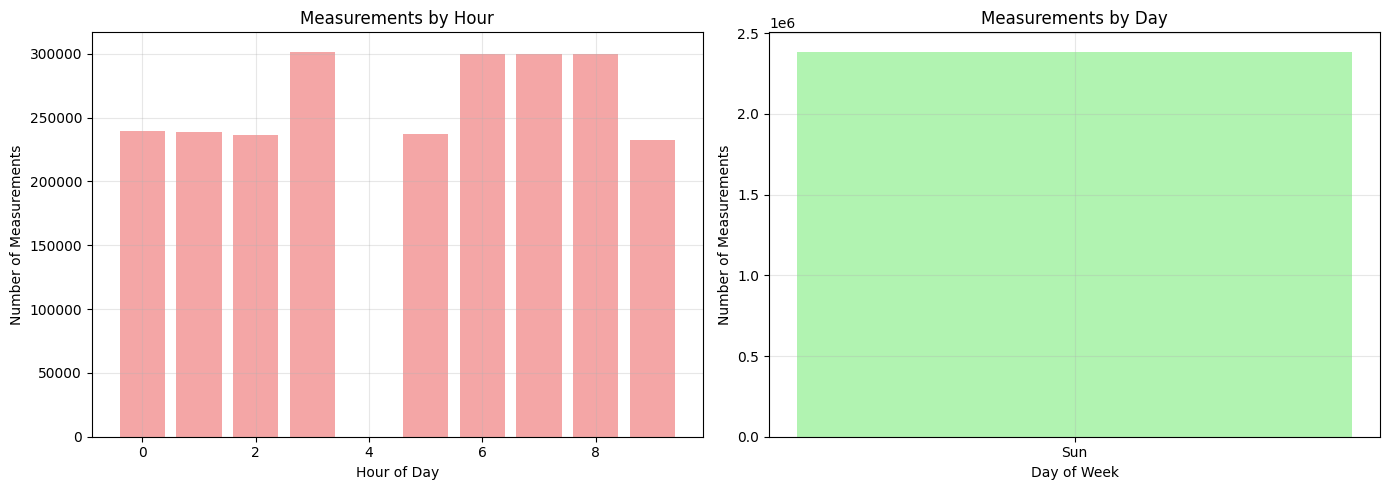

Temporal analysis complete:
- Hours with data: 9
- Days with data: 1


In [11]:
# Temporal patterns using streaming aggregation
temporal_stats = (
    df_filtered
    .with_columns([
        (pl.col("ts") * 1_000_000).cast(pl.Datetime("us")).dt.hour().alias("hour"),
        (pl.col("ts") * 1_000_000).cast(pl.Datetime("us")).dt.weekday().alias("day_of_week")
    ])
    .select(["hour", "day_of_week"])
)

# Get hourly and daily counts using streaming
hourly_counts = (
    temporal_stats
    .group_by("hour")
    .agg(pl.count().alias("count"))
    .sort("hour")
    .collect()
)

daily_counts = (
    temporal_stats
    .group_by("day_of_week") 
    .agg(pl.count().alias("count"))
    .sort("day_of_week")
    .collect()
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Hourly distribution
if hourly_counts.height > 0:
    hourly_df = hourly_counts.to_pandas()
    ax1.bar(hourly_df['hour'], hourly_df['count'], alpha=0.7, color='lightcoral')
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Number of Measurements')
    ax1.set_title('Measurements by Hour')
    ax1.grid(True, alpha=0.3)

# Daily distribution  
if daily_counts.height > 0:
    daily_df = daily_counts.to_pandas()
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    ax2.bar(range(len(daily_df)), daily_df['count'], alpha=0.7, color='lightgreen')
    ax2.set_xlabel('Day of Week')
    ax2.set_ylabel('Number of Measurements')
    ax2.set_title('Measurements by Day')
    if len(daily_df) <= len(days):
        ax2.set_xticks(range(len(daily_df)))
        ax2.set_xticklabels([days[i] for i in daily_df['day_of_week']])
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Temporal analysis complete:")
print(f"- Hours with data: {hourly_counts.height}")
print(f"- Days with data: {daily_counts.height}")

## Network Connectivity Analysis

Connectivity pairs for top 20 probes: 400


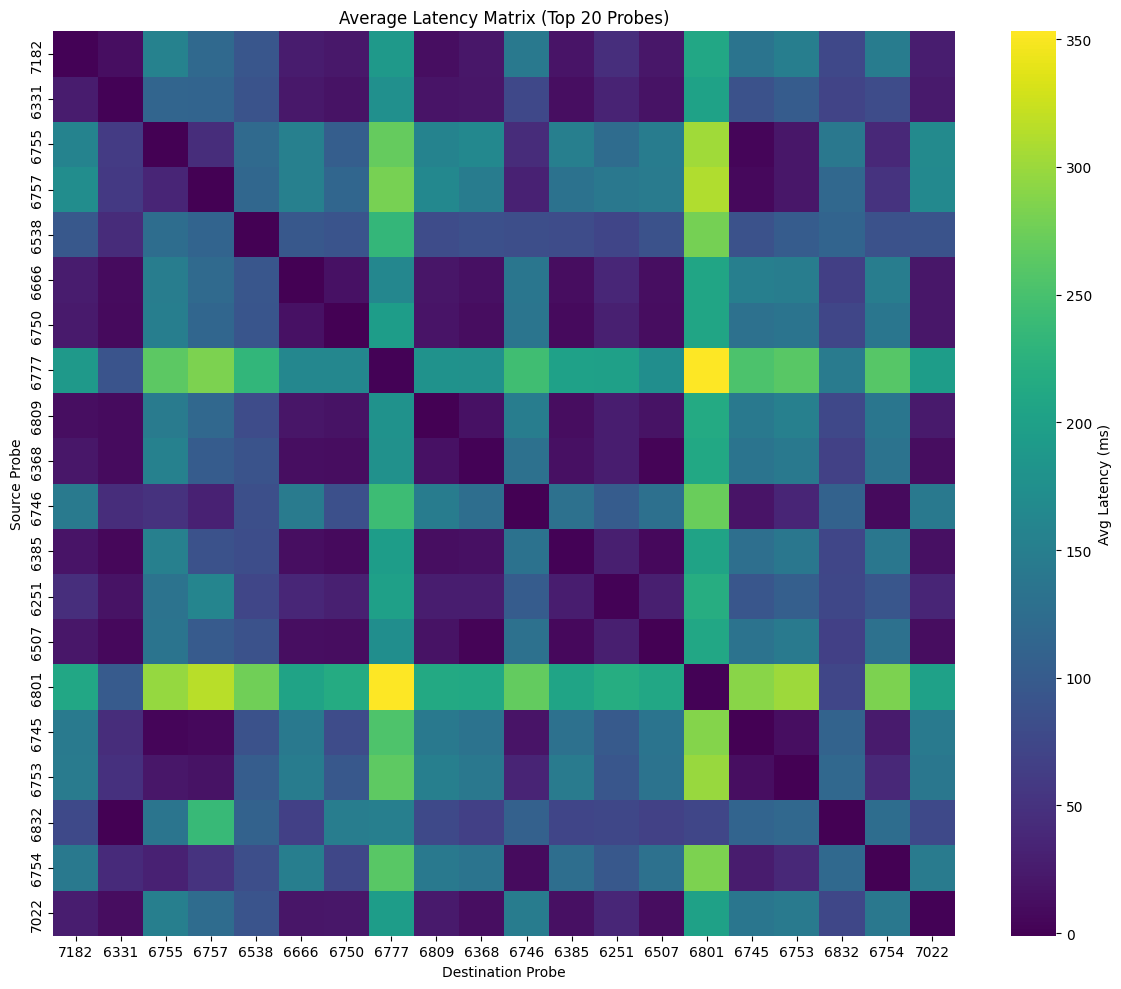

Connectivity matrix: 400 connections out of 400 possible


In [12]:
# Connectivity matrix for top 20 probes using streaming
top_20_probes = top_probes[:20]

# Stream connectivity data for top 20 probes only  
connectivity_data = (
    df_filtered.filter(
        pl.col("src").is_in(top_20_probes) & pl.col("dst").is_in(top_20_probes)
    )
    .group_by(["src", "dst"])
    .agg(pl.col("avg").mean().alias("avg_latency"))
    .collect()  # Collect only the aggregated matrix data
)

print(f"Connectivity pairs for top 20 probes: {connectivity_data.height}")

if connectivity_data.height > 0:
    # Convert to pandas for matrix operations
    conn_pandas = connectivity_data.to_pandas()
    
    try:
        # Create pivot table
        matrix = conn_pandas.pivot(index='src', columns='dst', values='avg_latency')
        matrix = matrix.reindex(index=top_20_probes, columns=top_20_probes)
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(matrix, annot=False, cmap='viridis', 
                   cbar_kws={'label': 'Avg Latency (ms)'},
                   mask=matrix.isna())  # Mask NaN values
        plt.title('Average Latency Matrix (Top 20 Probes)')
        plt.xlabel('Destination Probe')
        plt.ylabel('Source Probe')
        plt.tight_layout()
        plt.show()
        
        connections = matrix.notna().sum().sum()
        print(f"Connectivity matrix: {connections} connections out of {20*20} possible")
        
    except Exception as e:
        print(f"Could not create heatmap: {e}")
        print("Connectivity data sample:")
        print(connectivity_data.head(10))
else:
    print("No connectivity data found for top 20 probes")

## Packet Loss Analysis

Packet loss distribution:
  3 sent, 0 received (100.0% loss): 214,206 measurements
  3 sent, 1 received (66.7% loss): 1,257 measurements
  3 sent, 2 received (33.3% loss): 2,623 measurements
  3 sent, 3 received (0.0% loss): 2,168,226 measurements


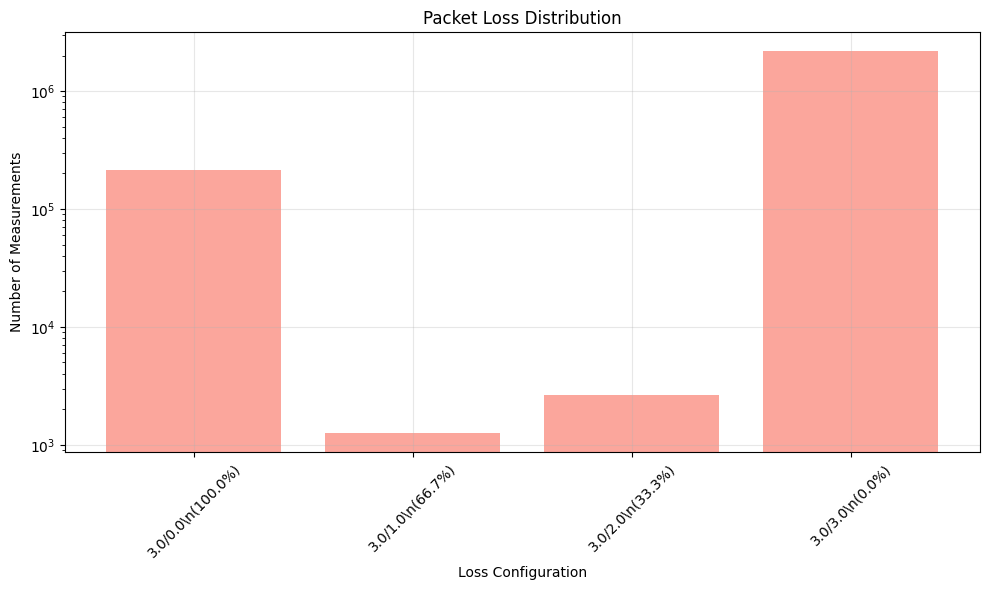

\nSummary:
- Total measurements: 2,386,312
- Successful (0% loss): 2,168,226 (90.9%)


In [13]:
# Packet loss statistics using streaming aggregation
loss_stats = (
    df_filtered
    .group_by(["sent", "rcvd"])
    .agg(pl.count().alias("count"))
    .sort(["sent", "rcvd"])
    .collect()
)

print("Packet loss distribution:")
if loss_stats.height > 0:
    for row in loss_stats.iter_rows(named=True):
        loss_rate = (row['sent'] - row['rcvd']) / row['sent'] * 100 if row['sent'] > 0 else 0
        print(f"  {row['sent']} sent, {row['rcvd']} received ({loss_rate:.1f}% loss): {row['count']:,} measurements")

    # Visualize packet loss
    loss_df = loss_stats.to_pandas()
    loss_df['loss_rate'] = (loss_df['sent'] - loss_df['rcvd']) / loss_df['sent'] * 100
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(len(loss_df)), loss_df['count'], alpha=0.7, color='salmon')
    plt.xlabel('Loss Configuration')
    plt.ylabel('Number of Measurements')
    plt.title('Packet Loss Distribution')
    
    # Create labels for x-axis
    labels = [f"{row['sent']}/{row['rcvd']}\\n({row['loss_rate']:.1f}%)" 
              for _, row in loss_df.iterrows()]
    plt.xticks(range(len(loss_df)), labels, rotation=45)
    
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    total_measurements = loss_df['count'].sum()
    successful = loss_df[loss_df['loss_rate'] == 0]['count'].sum() if (loss_df['loss_rate'] == 0).any() else 0
    print(f"\\nSummary:")
    print(f"- Total measurements: {total_measurements:,}")
    print(f"- Successful (0% loss): {successful:,} ({successful/total_measurements*100:.1f}%)")
    
else:
    print("No packet loss data found")

## Latency Variation Analysis

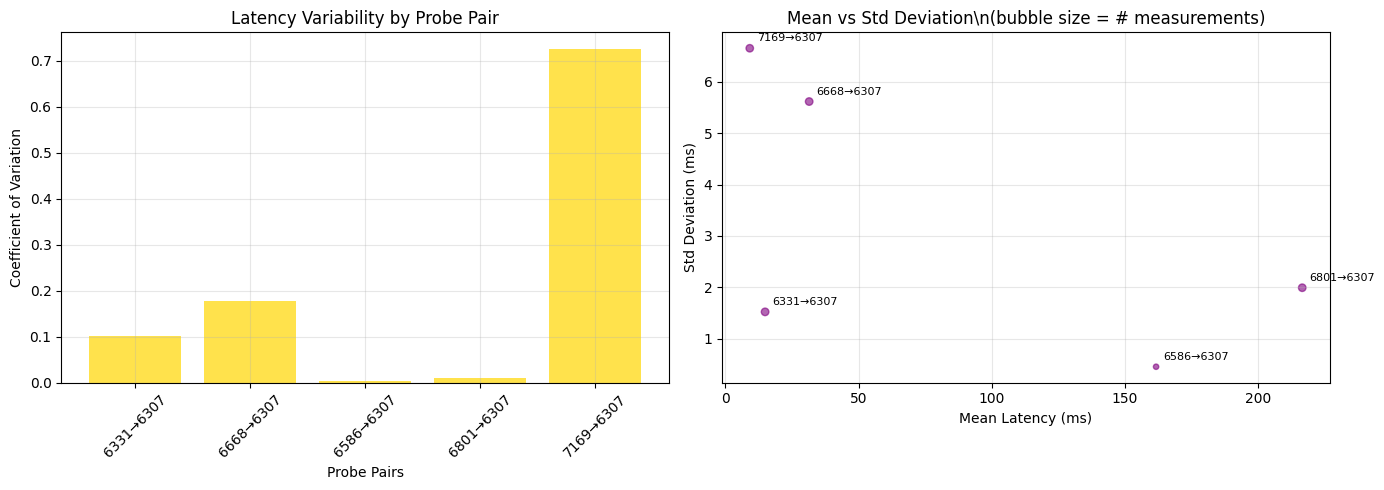

\nLatency variation summary:
  6331→6307: mean=14.92ms, std=1.52ms, CV=0.102
  6668→6307: mean=31.46ms, std=5.62ms, CV=0.179
  6586→6307: mean=161.66ms, std=0.45ms, CV=0.003
  6801→6307: mean=216.51ms, std=1.99ms, CV=0.009
  7169→6307: mean=9.17ms, std=6.65ms, CV=0.726


In [14]:
# Latency variation analysis for top pairs using streaming
if active_pairs.height > 0:
    variation_stats = []
    
    # Analyze top 5 pairs
    for row in active_pairs.head(5).iter_rows(named=True):
        src, dst = row['src'], row['dst']
        
        # Stream latency data for this specific pair
        pair_latencies = (
            df_filtered.filter(
                (pl.col("src") == src) & (pl.col("dst") == dst) & (pl.col("avg") > 0)
            )
            .select("avg")
            .collect()["avg"].to_list()
        )
        
        if len(pair_latencies) > 1:
            mean_lat = np.mean(pair_latencies)
            std_lat = np.std(pair_latencies)
            cv = std_lat / mean_lat if mean_lat > 0 else 0
            
            variation_stats.append({
                'pair': f"{src}→{dst}",
                'mean': mean_lat,
                'std': std_lat,
                'cv': cv,
                'count': len(pair_latencies)
            })

    # Plot coefficient of variation
    if variation_stats:
        var_df = pd.DataFrame(variation_stats)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Coefficient of variation bar chart
        ax1.bar(range(len(var_df)), var_df['cv'], alpha=0.7, color='gold')
        ax1.set_xlabel('Probe Pairs')
        ax1.set_ylabel('Coefficient of Variation')
        ax1.set_title('Latency Variability by Probe Pair')
        ax1.set_xticks(range(len(var_df)))
        ax1.set_xticklabels(var_df['pair'], rotation=45)
        ax1.grid(True, alpha=0.3)
        
        # Mean vs std scatter plot
        sizes = [count/10 for count in var_df['count']]  # Scale bubble sizes
        ax2.scatter(var_df['mean'], var_df['std'], s=sizes, alpha=0.6, color='purple')
        ax2.set_xlabel('Mean Latency (ms)')
        ax2.set_ylabel('Std Deviation (ms)')
        ax2.set_title('Mean vs Std Deviation\\n(bubble size = # measurements)')
        ax2.grid(True, alpha=0.3)
        
        # Add labels to scatter plot
        for i, row in var_df.iterrows():
            ax2.annotate(row['pair'], (row['mean'], row['std']), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        plt.tight_layout()
        plt.show()
        
        print("\\nLatency variation summary:")
        for _, row in var_df.iterrows():
            print(f"  {row['pair']}: mean={row['mean']:.2f}ms, std={row['std']:.2f}ms, CV={row['cv']:.3f}")
    else:
        print("No variation statistics could be calculated")
else:
    print("No active pairs available for variation analysis")

## Summary Statistics

In [16]:
# Overall summary using streaming operations
summary_stats = df_filtered.select([
    pl.len().alias("total_measurements"),
    ((pl.col("ts").max() - pl.col("ts").min()) / 3600).alias("time_span_hours"),
    pl.col("avg").mean().alias("mean_latency"),
    pl.col("avg").std().alias("std_latency"),
    (pl.col("rcvd") == 3).sum().alias("successful_measurements")
]).collect()

# Get unique pairs count
unique_pairs = df_filtered.select(["src", "dst"]).unique().select(pl.len()).collect().item()

# Get summary row
summary = summary_stats.row(0, named=True)

print("=== PING DATA ANALYSIS SUMMARY ===")
print(f"Dataset: {summary['total_measurements']:,} measurements")
print(f"Time span: {summary['time_span_hours']:.1f} hours")
print(f"Probe pairs: {unique_pairs:,}")
print(f"Average latency: {summary['mean_latency']:.2f} ± {summary['std_latency']:.2f} ms")

success_rate = (summary['successful_measurements'] / summary['total_measurements']) * 100
print(f"Successful measurements: {summary['successful_measurements']:,} ({success_rate:.1f}%)")

if active_pairs.height > 0:
    most_active = active_pairs.row(0, named=True)
    print(f"Most active pair: {most_active['src']} → {most_active['dst']} ({most_active['count']} measurements)")
else:
    print("Most active pair: None found")

print("\\n=== Analysis Complete ===")
print("Next: Temporal modelability visualizations for poster...")

=== PING DATA ANALYSIS SUMMARY ===
Dataset: 2,386,312 measurements
Time span: 10.0 hours
Probe pairs: 10,000
Average latency: 135.72 ± 102.24 ms
Successful measurements: 2,168,226 (90.9%)
Most active pair: 6331 → 6307 (296 measurements)
\n=== Analysis Complete ===
Next: Temporal modelability visualizations for poster...


# Temporal Modelability Analysis for Poster

The following visualizations demonstrate the temporal structure and modelability of network latency data.

In [ ]:
# POSTER VISUAL 1: Multi-Scale Autocorrelation Analysis
import numpy as np
from scipy.stats import pearsonr

def calculate_autocorr(ts_data, max_lag=120):
    """Calculate autocorrelation up to max_lag measurements"""
    autocorrs = []
    for lag in range(1, max_lag + 1):
        if len(ts_data) > lag:
            corr, _ = pearsonr(ts_data[:-lag], ts_data[lag:])
            autocorrs.append(corr if not np.isnan(corr) else 0)
        else:
            autocorrs.append(0)
    return autocorrs

# Get probe pairs with enough temporal data
pairs_for_autocorr = []
if active_pairs.height > 0:
    for row in active_pairs.head(10).iter_rows(named=True):  # Use top 10 pairs
        src, dst = row['src'], row['dst']
        
        # Get time series data for this pair
        pair_ts = (
            df_filtered.filter(
                (pl.col("src") == src) & (pl.col("dst") == dst) & (pl.col("avg") > 0)
            )
            .sort("ts")
            .select(["ts", "avg"])
            .collect()
        )
        
        if pair_ts.height >= 60:  # Need at least 60 points for autocorr
            pairs_for_autocorr.append({
                'pair': f"{src}→{dst}",
                'ts': pair_ts["ts"].to_list(),
                'latency': pair_ts["avg"].to_list()
            })

print(f"Found {len(pairs_for_autocorr)} pairs suitable for autocorrelation analysis")

if len(pairs_for_autocorr) > 0:
    # Calculate autocorrelations
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Different time scales (in measurement lags)
    scales = [
        {"name": "Short-term", "max_lag": 20, "xlabel": "Lag (measurements)", "ax": axes[0]},
        {"name": "Medium-term", "max_lag": 40, "xlabel": "Lag (measurements)", "ax": axes[1]}, 
        {"name": "Long-term", "max_lag": 60, "xlabel": "Lag (measurements)", "ax": axes[2]}
    ]
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(pairs_for_autocorr)))
    
    for scale in scales:
        ax = scale["ax"]
        max_lag = scale["max_lag"]
        
        for i, pair_data in enumerate(pairs_for_autocorr):
            latency_data = pair_data["latency"]
            if len(latency_data) >= max_lag:
                autocorrs = calculate_autocorr(latency_data, max_lag)
                lags = list(range(1, len(autocorrs) + 1))
                
                ax.plot(lags, autocorrs, alpha=0.7, color=colors[i], 
                       label=pair_data["pair"] if i < 3 else "")  # Only label first 3
        
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax.axhline(y=0.1, color='red', linestyle=':', alpha=0.5, label='Weak correlation')
        ax.set_xlabel(scale["xlabel"])
        ax.set_ylabel("Autocorrelation")
        ax.set_title(scale["name"])
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.5, 1.0)
        
        if scale["name"] == "Short-term":  # Only show legend on first plot
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    plt.suptitle("Autocorrelation Analysis: Temporal Memory at Multiple Scales", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print("✅ Multi-scale autocorrelation analysis complete")
    print("Key insight: Different probe pairs show varying degrees of temporal memory")
else:
    print("⚠️ Not enough data for autocorrelation analysis")

In [ ]:
# POSTER VISUAL 2: Time Series + Distribution Hybrid
if len(pairs_for_autocorr) > 0:
    # Select the most active pair with sufficient data
    best_pair = pairs_for_autocorr[0]  # First pair has most data
    ts_data = best_pair["ts"]
    latency_data = best_pair["latency"]
    
    # Convert timestamps to hours from start
    start_time = min(ts_data)
    time_hours = [(t - start_time) / 3600 for t in ts_data]
    
    fig = plt.figure(figsize=(16, 8))
    gs = fig.add_gridspec(2, 2, height_ratios=[3, 1], width_ratios=[3, 1])
    
    # Main time series plot
    ax_main = fig.add_subplot(gs[0, 0])
    ax_main.plot(time_hours, latency_data, alpha=0.7, linewidth=1, color='navy')
    ax_main.set_xlabel('Time (hours from start)')
    ax_main.set_ylabel('Latency (ms)')
    ax_main.set_title(f'Temporal Latency Pattern: {best_pair["pair"]}')
    ax_main.grid(True, alpha=0.3)
    
    # Moving average overlay
    window = min(20, len(latency_data) // 10)  # Adaptive window size
    if window > 1:
        moving_avg = np.convolve(latency_data, np.ones(window)/window, mode='valid')
        moving_time = time_hours[(window-1):]
        ax_main.plot(moving_time, moving_avg, color='red', linewidth=2, 
                    label=f'Moving Average (n={window})')
        ax_main.legend()
    
    # Marginal distribution on right
    ax_right = fig.add_subplot(gs[0, 1])
    ax_right.hist(latency_data, bins=30, orientation='horizontal', alpha=0.7, 
                 color='lightblue', edgecolor='black')
    ax_right.set_xlabel('Frequency')
    ax_right.set_title('Distribution')
    ax_right.grid(True, alpha=0.3)
    
    # Temporal stability indicator at bottom
    ax_bottom = fig.add_subplot(gs[1, 0])
    
    # Calculate rolling coefficient of variation 
    chunk_size = max(10, len(latency_data) // 20)  # Adaptive chunk size
    rolling_cv = []
    rolling_time = []
    
    for i in range(0, len(latency_data) - chunk_size + 1, chunk_size // 2):
        chunk = latency_data[i:i + chunk_size]
        if len(chunk) > 1:
            chunk_mean = np.mean(chunk)
            chunk_std = np.std(chunk)
            cv = chunk_std / chunk_mean if chunk_mean > 0 else 0
            rolling_cv.append(cv)
            rolling_time.append(time_hours[i + chunk_size // 2])
    
    if rolling_cv:
        ax_bottom.plot(rolling_time, rolling_cv, color='green', linewidth=2, marker='o', markersize=4)
        ax_bottom.set_xlabel('Time (hours from start)')
        ax_bottom.set_ylabel('Coefficient of\\nVariation')
        ax_bottom.set_title('Temporal Stability (lower = more stable)')
        ax_bottom.grid(True, alpha=0.3)
        
        # Add stability threshold line
        stable_threshold = 0.3  # Typical threshold for "stable" systems
        ax_bottom.axhline(y=stable_threshold, color='orange', linestyle='--', 
                         label=f'Stability threshold ({stable_threshold})')
        ax_bottom.legend()
    
    plt.suptitle('Hybrid Temporal-Statistical Analysis for Modelability Assessment', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print quantitative insights
    mean_cv = np.mean(rolling_cv) if rolling_cv else 0
    stability_status = "Stable" if mean_cv < 0.3 else "Variable" if mean_cv < 0.6 else "Highly Variable"
    
    print(f"✅ Time series + distribution analysis complete")
    print(f"Temporal stability: {stability_status} (CV = {mean_cv:.3f})")
    print(f"Data points: {len(latency_data)}, Time span: {max(time_hours):.1f} hours")
    
else:
    print("⚠️ No suitable data for time series analysis")

In [ ]:
# POSTER VISUAL 3: Latency Stability Classification
if active_pairs.height > 0:
    # Classify probe pairs by temporal stability characteristics
    stability_analysis = []
    
    for row in active_pairs.head(20).iter_rows(named=True):  # Use top 20 pairs
        src, dst = row['src'], row['dst']
        
        # Get latency data for this pair
        pair_latencies = (
            df_filtered.filter(
                (pl.col("src") == src) & (pl.col("dst") == dst) & (pl.col("avg") > 0)
            )
            .sort("ts")
            .select("avg")
            .collect()["avg"].to_list()
        )
        
        if len(pair_latencies) >= 20:  # Need sufficient data
            mean_lat = np.mean(pair_latencies)
            std_lat = np.std(pair_latencies)
            cv = std_lat / mean_lat if mean_lat > 0 else 0
            
            # Calculate trend (linear regression slope)
            x = np.arange(len(pair_latencies))
            slope = np.polyfit(x, pair_latencies, 1)[0] if len(pair_latencies) > 1 else 0
            
            # Classify stability
            if cv < 0.2:
                stability_class = "Highly Stable"
                color = "green"
            elif cv < 0.4:
                stability_class = "Moderately Stable" 
                color = "orange"
            else:
                stability_class = "Variable"
                color = "red"
            
            # Classify trend
            abs_slope = abs(slope) * len(pair_latencies)  # Scale by length for interpretability
            if abs_slope < 1:
                trend_class = "No Trend"
            elif slope > 0:
                trend_class = "Increasing"
            else:
                trend_class = "Decreasing" 
            
            stability_analysis.append({
                'pair': f"{src}→{dst}",
                'mean': mean_lat,
                'cv': cv,
                'slope': slope,
                'stability_class': stability_class,
                'trend_class': trend_class,
                'color': color,
                'count': len(pair_latencies)
            })
    
    if stability_analysis:
        # Create comprehensive stability visualization
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. CV vs Mean Latency scatter (Stability Landscape)
        for item in stability_analysis:
            ax1.scatter(item['mean'], item['cv'], 
                       color=item['color'], s=item['count']/2, alpha=0.7,
                       label=item['stability_class'] if item['stability_class'] not in [s.get_text() for s in ax1.get_legend().get_texts()] if ax1.get_legend() else True else "")
        
        ax1.set_xlabel('Mean Latency (ms)')
        ax1.set_ylabel('Coefficient of Variation')
        ax1.set_title('Stability Landscape\\n(size = measurement count)')
        ax1.grid(True, alpha=0.3)
        
        # Add stability zones
        ax1.axhline(y=0.2, color='green', linestyle='--', alpha=0.5, label='Highly Stable')
        ax1.axhline(y=0.4, color='orange', linestyle='--', alpha=0.5, label='Moderately Stable')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # 2. Stability class distribution
        stability_counts = {}
        for item in stability_analysis:
            stability_counts[item['stability_class']] = stability_counts.get(item['stability_class'], 0) + 1
        
        classes = list(stability_counts.keys())
        counts = list(stability_counts.values())
        colors_bar = ['green' if 'Highly' in c else 'orange' if 'Moderately' in c else 'red' for c in classes]
        
        ax2.bar(classes, counts, color=colors_bar, alpha=0.7)
        ax2.set_ylabel('Number of Probe Pairs')
        ax2.set_title('Stability Classification Distribution')
        ax2.grid(True, alpha=0.3)
        
        # 3. Temporal trends analysis
        trend_counts = {}
        for item in stability_analysis:
            trend_counts[item['trend_class']] = trend_counts.get(item['trend_class'], 0) + 1
        
        trend_classes = list(trend_counts.keys())
        trend_count_values = list(trend_counts.values())
        trend_colors = ['blue' if 'No' in t else 'red' if 'Increasing' in t else 'purple' for t in trend_classes]
        
        ax3.bar(trend_classes, trend_count_values, color=trend_colors, alpha=0.7)
        ax3.set_ylabel('Number of Probe Pairs')
        ax3.set_title('Temporal Trend Distribution')
        ax3.grid(True, alpha=0.3)
        
        # 4. Modelability score heatmap
        # Create modelability score: higher stability + predictable trends = better modelability
        for item in stability_analysis:
            stability_score = 1 - item['cv']  # Higher when more stable
            trend_score = 1 if item['trend_class'] == 'No Trend' else 0.5  # Stable trends are more modelable
            item['modelability'] = (stability_score + trend_score) / 2
        
        # Sort by modelability for better visualization
        stability_analysis.sort(key=lambda x: x['modelability'], reverse=True)
        
        pairs = [item['pair'] for item in stability_analysis[:15]]  # Top 15 for readability
        modelability_scores = [item['modelability'] for item in stability_analysis[:15]]
        
        bars = ax4.barh(range(len(pairs)), modelability_scores, 
                       color=[item['color'] for item in stability_analysis[:15]], alpha=0.7)
        ax4.set_yticks(range(len(pairs)))
        ax4.set_yticklabels(pairs, fontsize=8)
        ax4.set_xlabel('Modelability Score (0-1)')
        ax4.set_title('Probe Pair Modelability Ranking')
        ax4.grid(True, alpha=0.3)
        
        # Add score labels on bars
        for i, (bar, score) in enumerate(zip(bars, modelability_scores)):
            ax4.text(score + 0.01, i, f'{score:.2f}', va='center', fontsize=8)
        
        plt.suptitle('Temporal Modelability Classification for Network Latency', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # Summary statistics
        total_pairs = len(stability_analysis)
        highly_stable = sum(1 for item in stability_analysis if item['stability_class'] == 'Highly Stable')
        no_trend = sum(1 for item in stability_analysis if item['trend_class'] == 'No Trend')
        high_modelability = sum(1 for item in stability_analysis if item['modelability'] > 0.7)
        
        print(f"✅ Stability classification complete")
        print(f"Total probe pairs analyzed: {total_pairs}")
        print(f"Highly stable pairs: {highly_stable} ({highly_stable/total_pairs*100:.1f}%)")
        print(f"Trend-less pairs: {no_trend} ({no_trend/total_pairs*100:.1f}%)")
        print(f"High modelability pairs: {high_modelability} ({high_modelability/total_pairs*100:.1f}%)")
        
        # Best candidates for modeling
        best_candidates = [item for item in stability_analysis if item['modelability'] > 0.7][:5]
        if best_candidates:
            print("\\nBest candidates for temporal modeling:")
            for item in best_candidates:
                print(f"  {item['pair']}: modelability={item['modelability']:.3f}, CV={item['cv']:.3f}, trend={item['trend_class']}")
    else:
        print("⚠️ Not enough data for stability classification")
else:
    print("⚠️ No active pairs available for stability analysis")